### import libraries 

In [1]:
import pandas as pd
import sys
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

#### Instructions on how to downlaod the samples and sequecing metadata are here https://anvilproject.org/learn/reference/gtex-v8-free-egress-instructions

### Read the files from GTEx with the samples attributes and the sequencing attributes and create a GTEx_sample_QCed_dataframe with the merge

In [3]:
samples_sequencing_attributes=pd.read_table("./tsvs/sequencing.tsv")

In [4]:
samples_attributes=pd.read_table("./tsvs/sample.tsv")

In [5]:
samples_attributes.shape

(17350, 29)

In [6]:
GTEx_sample_QCed_dataframe=pd.merge(samples_sequencing_attributes,samples_attributes, left_on="samples.submitter_id", right_on="submitter_id")

In [7]:
GTEx_sample_QCed_dataframe.shape

(17350, 118)

In [8]:
#sanity check
GTEx_sample_QCed_dataframe.loc[1,["specimen_id","samples.submitter_id"]]

specimen_id             GTEX-15SDE-0726-SM-6M48Q
samples.submitter_id    GTEX-15SDE-0726-SM-6M48Q
Name: 1, dtype: object

In [9]:
GTEx_sample_QCed_dataframe.columns

Index(['type_x', 'alignment_method', 'analyte_type', 'capture_region_bed_file',
       'data_processing_pipeline', 'date_data_generation',
       'experimental_strategy', 'exome_capture_platform',
       'functional_equivalence_standard', 'library_prep_kit_method',
       ...
       'total_ischemic_time', 'paxgene_time', 'submitter_id_y', 'state_y',
       'project_id_y', 'created_datetime_y', 'updated_datetime_y', 'id_y',
       'subjects.id', 'subjects.submitter_id'],
      dtype='object', length=118)

In [10]:
#Number of different subjects
len(GTEx_sample_QCed_dataframe.loc[:,"subjects.submitter_id"].unique())

948

In [11]:
#Number of different tissues
print(len(GTEx_sample_QCed_dataframe.loc[:,"tissue_type"].unique()))
print(len(GTEx_sample_QCed_dataframe.loc[:,"tissue_type_detail"].unique()))

30
54


### Check how many samples have missing metadata in the variables of interest. 
Autolysis Score

Nucleic Acid Isolation Batch ID

SMNABTCHD : Date of nucleic acid isolation batch

SMGEBTCH : Genotype or Expression Batch ID

SMGEBTCHD : Date of genotype or expression batch

SMCENTER : Code for BSS collection site

SMRIN : RIN Number

SMTSISCH : Total Ischemic time for a sample

SMTS : Tissue Type, area from which the tissue sample was taken.  This is a parent value to SMTSD.

SMTSD : Tissue Type, more specific detail of tissue type

SMRDTTL : Total: Total reads (filtered to exclude reads with vendor fail or alternative alignment flags)

In [12]:
print("Nan values in autolysis_score:",GTEx_sample_QCed_dataframe["autolysis_score"].isnull().sum())
print("Nan values in nucleic_acid_isolation_batch_id:",GTEx_sample_QCed_dataframe["nucleic_acid_isolation_batch_id"].isnull().sum())
print("Nan values in date_nucleic_acid_isolation:",GTEx_sample_QCed_dataframe["date_nucleic_acid_isolation"].isnull().sum())
print("Nan values in genotype_expression_batch_id:",GTEx_sample_QCed_dataframe["genotype_expression_batch_id"].isnull().sum())
print("Nan values in date_genotype_expression:",GTEx_sample_QCed_dataframe["date_genotype_expression"].isnull().sum())
print("Nan values in bss_collection_site:",GTEx_sample_QCed_dataframe["bss_collection_site"].isnull().sum())
print("Nan values in rin_number:",GTEx_sample_QCed_dataframe["rin_number"].isnull().sum())
print("Nan values in total_ischemic_time:",GTEx_sample_QCed_dataframe["total_ischemic_time"].isnull().sum())
print("Nan values in tissue_type:",GTEx_sample_QCed_dataframe["tissue_type"].isnull().sum())
print("Nan values in tissue_type_detail:",GTEx_sample_QCed_dataframe["tissue_type_detail"].isnull().sum())
print("Nan values in total_reads:",GTEx_sample_QCed_dataframe["total_reads"].isnull().sum())

Nan values in autolysis_score: 3580
Nan values in nucleic_acid_isolation_batch_id: 0
Nan values in date_nucleic_acid_isolation: 0
Nan values in genotype_expression_batch_id: 10
Nan values in date_genotype_expression: 16
Nan values in bss_collection_site: 10
Nan values in rin_number: 0
Nan values in total_ischemic_time: 26
Nan values in tissue_type: 0
Nan values in tissue_type_detail: 0
Nan values in total_reads: 0


In [13]:
GTEx_sample_QCed_dataframe.groupby("current_material_type").size()

current_material_type
Cells:Pellet frozen                678
Tissue:Fresh Frozen Tissue        2146
Tissue:PAXgene Preserved         13771
Whole Blood:PAXgene Preserved      739
Whole Blood:Whole Blood             16
dtype: int64

### Keep only the samples without missing values in the above variables

In [15]:
GTEx_sample_QCed_dataframe_notNA=GTEx_sample_QCed_dataframe

In [16]:
GTEx_sample_QCed_dataframe_notNA.dropna(subset=["nucleic_acid_isolation_batch_id", "date_nucleic_acid_isolation", 
                                                "date_genotype_expression", "genotype_expression_batch_id", 
                                                "bss_collection_site", "rin_number", "total_ischemic_time", 
                                                "tissue_type", "tissue_type_detail", "total_reads"], inplace=True)

In [17]:
GTEx_sample_QCed_dataframe_notNA.shape

(17298, 118)

### Keep the samples that their material type was Tissue:PAXgene Preserved and or  Whole Blood:PAXgene Preserved
Cells:Pellet frozen , Tissue:Fresh Frozen Tissue, Whole Blood:PAXgene Preserved, Whole Blood:Whole Blood 

In [18]:
GTEx_sample_QCed_dataframe_notNA_MaterialType=GTEx_sample_QCed_dataframe_notNA[(GTEx_sample_QCed_dataframe_notNA["current_material_type"]=="Tissue:PAXgene Preserved") | (GTEx_sample_QCed_dataframe_notNA["current_material_type"]=="Whole Blood:PAXgene Preserved")]

In [19]:
GTEx_sample_QCed_dataframe_notNA_MaterialType.shape

(14478, 118)

#### Remove the samples from tissues with less than 20 samples 

In [20]:
GTEx_sample_QCed_dataframe_notNA_MaterialType.groupby("tissue_type_detail").size()

tissue_type_detail
Adipose - Subcutaneous                   661
Adipose - Visceral (Omentum)             540
Adrenal Gland                            257
Artery - Aorta                           430
Artery - Coronary                        240
Artery - Tibial                          662
Bladder                                   21
Brain - Cerebellum                       241
Brain - Cortex                           255
Breast - Mammary Tissue                  457
Cervix - Ectocervix                        9
Cervix - Endocervix                       10
Colon - Sigmoid                          373
Colon - Transverse                       405
Esophagus - Gastroesophageal Junction    375
Esophagus - Mucosa                       548
Esophagus - Muscularis                   509
Fallopian Tube                             9
Heart - Atrial Appendage                 429
Heart - Left Ventricle                   427
Kidney - Cortex                           85
Kidney - Medulla                    

In [21]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples=GTEx_sample_QCed_dataframe_notNA_MaterialType[~GTEx_sample_QCed_dataframe_notNA_MaterialType["tissue_type_detail"].isin(["Fallopian Tube", "Kidney - Medulla","Cervix - Ectocervix", "Cervix - Endocervix"])]

In [22]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples.shape

(14446, 118)

#### Regarding BSS collection site

In [23]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples["bss_collection_site"].value_counts()

B1    10106
C1     4262
D1       78
Name: bss_collection_site, dtype: int64

#### Regarding the distribution of RIN across samples

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,   5.,
        110.,   0., 154., 336.,   0., 394., 395.,   0., 408., 425.,   0.,
        465., 452.,   0., 452., 465., 509.,   0., 512., 532.,   0., 523.,
        554.,   0., 559., 534.,   0., 538., 511.,   0., 478., 483.,   0.,
        437., 451.,   0., 444., 438.,   0., 413., 370.,   0., 327., 275.,
        237.,   0., 215., 209.,   0., 167., 138.,   0.,  99., 107.,   0.,
         77.,  48.,   0.,  50.,  39.,   0.,  43.,  24.,   0.,  19.,   9.,
         10.]),
 array([ 3.20000005,  3.26800005,  3.33600005,  3.40400005,  3.47200005,
         3.54000005,  3.60800004,  3.67600004,  3.74400004,  3.81200004,
         3.88000004,  3.94800004,  4.01600004,  4.08400004,  4.15200004,
         4.22000004,  4.28800004,  4.35600004,  4.42400004,  4.49200004,
         4.56000004,  4.62

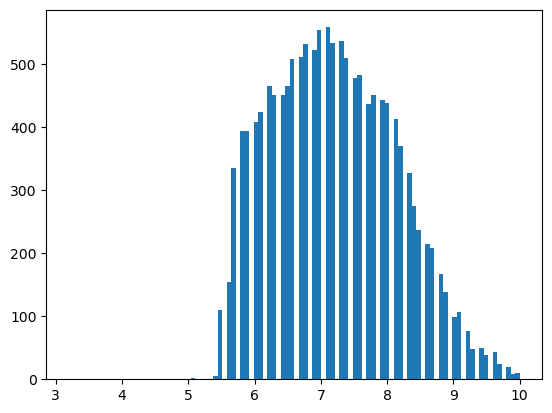

In [24]:
plt.hist(GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples["rin_number"], bins=100)

#### Delete the samples with RIN less than 5

In [25]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin=GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples[~(GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples["rin_number"]<5)]

In [26]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin.shape

(14443, 118)

#### Regarding the autolysis score 

In [27]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin["autolysis_score"].value_counts()

Mild        9096
None        3118
Moderate    1334
Severe       161
Name: autolysis_score, dtype: int64

#### Regarding the Nucleic Acid Isolation Batch ID

In [28]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin["nucleic_acid_isolation_batch_id"].value_counts()

BP-79140    80
BP-52773    79
BP-43072    76
BP-67135    76
BP-73690    76
            ..
BP-42407     1
BP-65860     1
BP-66268     1
BP-18358     1
BP-28780     1
Name: nucleic_acid_isolation_batch_id, Length: 973, dtype: int64

#### Regarding the Date of nucleic acid isolation batch

In [29]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin["date_nucleic_acid_isolation"].value_counts()

1/6/14      144
11/1/13     129
10/29/13    128
10/22/13    127
12/13/13    125
           ... 
3/2/15        1
4/7/12        1
8/5/11        1
10/19/12      1
8/2/12        1
Name: date_nucleic_acid_isolation, Length: 614, dtype: int64

#### Regarding the Genotype or Expression Batch ID

In [30]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin["genotype_expression_batch_id"].value_counts()

LCSET-4417                 95
LCSET-4955                 93
LCSET-4805                 93
LCSET-6806                 93
LCSET-9104                 92
                           ..
LCSET-4170,LCSET-4523       1
LCSET-10975,LCSET-11230     1
LCSET-4900,LCSET-5338       1
LCSET-7849,LCSET-8322       1
LCSET-7847,LCSET-8170       1
Name: genotype_expression_batch_id, Length: 395, dtype: int64

#### Regarding the Date of genotype or expression batch

In [31]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin["date_genotype_expression"].value_counts()

3/23/14     569
1/14/15     383
3/22/14     379
12/16/12    354
9/11/12     277
           ... 
4/13/13       1
9/9/14        1
5/11/13       1
1/27/13       1
4/2/14        1
Name: date_genotype_expression, Length: 226, dtype: int64

#### Regarding the total ischemic time for a sample

(array([  1.,   1.,   0.,   0.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   1.,   0.,   2.,   2.,   3.,   7.,  20.,  20.,
         31.,  54.,  62.,  67.,  39.,   9.,  49., 252., 725., 915., 853.,
        791., 651., 506., 369., 330., 373., 332., 326., 449., 425., 340.,
        355., 318., 312., 332., 277., 321., 303., 305., 322., 290., 284.,
        326., 266., 251., 252., 192., 206., 173., 146., 154., 156., 179.,
        156., 177., 143.,  90.,  23.,  16.,  14.,  24.,  21.,   9.,  22.,
          3.,   5.,   3.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          2.]),
 array([-1287.  , -1253.37, -1219.74, -1186.11, -1152.48, -1118.85,
        -1085.22, -1051.59, -1017.96,  -984.33,  -950.7 ,  -917.07,
         -883.44,  -849.81,  -816.18,  -782.55,  -748.92,  -715.29,
         -681.66,  -648.03,  -614.4 ,  -580.77,  -547.14,  -513.51,
         -479.88,  -446.25,  -412.62,  -378.99

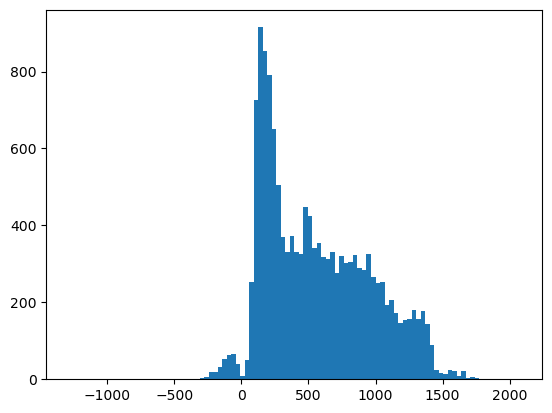

In [32]:
plt.hist(GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin["total_ischemic_time"], bins=100)

#### Remove the samples (139 samples) with total ischemic time more than 1440 minutes (24hours)

In [33]:
GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin_ischemic = GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin[~(GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin["total_ischemic_time"]>1440)]

### End of QC

### The variable QCed_samples_metadata contains the metadata of all the QC that I have done

#### QC steps: 
1) Use the GTEx QC

2) Remove the samples with NA even in one variable of interest

3) Keep only samples from Tissue:PAXgene Preserved 

4) Keep only tissues (tissue_type_detail) with more than 20 samples

5) Remove samples with RIN < 5 

6) Remove samples with total ischemic time more than 24h 

In [34]:
QCed_samples_metadata=GTEx_sample_QCed_dataframe_notNA_MaterialType_notFewSamples_rin_ischemic

In [35]:
QCed_samples_metadata.shape

(14304, 118)

## See some basic statistics of metadata

### Number of different tissues

In [36]:
len(QCed_samples_metadata["tissue_type_detail"].value_counts())

37

In [37]:
len(QCed_samples_metadata["tissue_type"].value_counts())

28

### Number of subjects 

In [38]:
len(set([sample[1] for sample in QCed_samples_metadata["subjects.submitter_id"].str.split("-")]))

942

### Total number of samples

In [39]:
QCed_samples_metadata.shape

(14304, 118)

### The frequencies of the different tissues in the final data

In [40]:
QCed_samples_metadata["tissue_type_detail"].value_counts()

Muscle - Skeletal                        791
Whole Blood                              733
Skin - Sun Exposed (Lower leg)           691
Adipose - Subcutaneous                   656
Artery - Tibial                          655
Thyroid                                  644
Nerve - Tibial                           615
Skin - Not Sun Exposed (Suprapubic)      597
Lung                                     568
Esophagus - Mucosa                       541
Adipose - Visceral (Omentum)             533
Esophagus - Muscularis                   501
Breast - Mammary Tissue                  454
Heart - Atrial Appendage                 426
Artery - Aorta                           426
Heart - Left Ventricle                   424
Colon - Transverse                       403
Esophagus - Gastroesophageal Junction    371
Colon - Sigmoid                          370
Testis                                   356
Stomach                                  352
Pancreas                                 324
Pituitary 

### Subject QC

In [41]:
subject_attributes=pd.read_table("./tsvs/subject.tsv")

In [42]:
QCed_samples_metadata["subject_ID"]=["GTEX-"+x.split("-")[1] for x in QCed_samples_metadata["specimen_id"]]

/tmp/ipykernel_4149099/1558919321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QCed_samples_metadata["subject_ID"]=["GTEX-"+x.split("-")[1] for x in QCed_samples_metadata["specimen_id"]]


In [43]:
metadata_all=pd.merge(QCed_samples_metadata,subject_attributes,left_on="subject_ID",right_on="submitter_id")

In [44]:
metadata_all.shape

(14304, 350)

In [45]:
subject_attributes_samplesQCed=subject_attributes[subject_attributes["submitter_id"].isin(QCed_samples_metadata["subject_ID"])]

In [46]:
len(subject_attributes_samplesQCed)

942

### History Check
Check how many subjects of each variable have each attribute

In [47]:
def print_attribute_size(pd_dataframe,attribute):
    print(pd_dataframe.groupby(attribute).size())
    print("------------------------------------")

###### https://ftp.ncbi.nlm.nih.gov/dbgap/studies/phs000424/phs000424.v9.p2/pheno_variable_summaries/phs000424.v9.pht002742.v9.GTEx_Subject_Phenotypes.data_dict.xml explainning the terms 

### Remove the subjects that are not Eligible For Study

In [48]:
subject_attributes_samplesQCed["eligible_for_study"]

0      True
1      True
2      True
3      True
4      True
       ... 
943    True
944    True
945    True
946    True
947    True
Name: eligible_for_study, Length: 942, dtype: bool

In [49]:
len(subject_attributes_samplesQCed[subject_attributes_samplesQCed["eligible_for_study"]==False]["source_subject_id"])

9

In [50]:
subject_attributes_samplesQCed_Eligible=subject_attributes_samplesQCed[~(subject_attributes_samplesQCed["eligible_for_study"]==False)]

In [51]:
len(subject_attributes_samplesQCed_Eligible)

933

### Some subjects were at the time of sampling, diagnosed with cancer or have 5years history of cancer
Remove these subjects

In [52]:
len(subject_attributes_samplesQCed_Eligible[subject_attributes_samplesQCed_Eligible["current_diagnosed_cancer"]=="Yes"])

7

In [53]:
subject_attributes_samplesQCed_Eligible_noCancer=subject_attributes_samplesQCed_Eligible[~(subject_attributes_samplesQCed_Eligible["current_diagnosed_cancer"]=="Yes")]

In [54]:
subject_attributes_samplesQCed_Eligible_noCancer2=subject_attributes_samplesQCed_Eligible_noCancer[~(subject_attributes_samplesQCed_Eligible_noCancer["five_years_diagnosed_cancer"]=="Yes")]

In [55]:
len(subject_attributes_samplesQCed_Eligible_noCancer2)

910

### Exploring history attributes

In [56]:
patients=subject_attributes_samplesQCed_Eligible_noCancer2[(subject_attributes_samplesQCed_Eligible_noCancer2["als_history"]=="Yes") | 
                   (subject_attributes_samplesQCed_Eligible_noCancer2["alzheimer_history"]=="Yes") |
                   (subject_attributes_samplesQCed_Eligible_noCancer2["alzheimer_or_dementia_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["arthritis_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["ascites_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["asthma_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["cerebrovascular_disease_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["clrd_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["copd_clrd_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["creutzfeldt_jakob_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["current_diagnosed_cancer"]=="Yes")|
                    (subject_attributes_samplesQCed_Eligible_noCancer2["dementia_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["depression_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["diabetes_i_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["diabetes_ii_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["dialysis_treatment"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["five_years_diagnosed_cancer"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["fugal_infection_at_death"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["gonorrhea_at_death"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["heart_attack_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["heart_disease_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["hemophilia_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["hypertension_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["ischemic_heart_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["kidney_inflammation_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["liver_disease_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["multiple_sclerosis"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["non_metastatic_cancer"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["osteomyelitis_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["parkinson_history"]=="Yes") | 
                    (subject_attributes_samplesQCed_Eligible_noCancer2["received_tissue_organ_transplant"]=="Yes")|
                    (subject_attributes_samplesQCed_Eligible_noCancer2["renal_failure_history"]=="Yes") |
                    (subject_attributes_samplesQCed_Eligible_noCancer2["rheumatoid_arthritis_history"]=="Yes")|
                    (subject_attributes_samplesQCed_Eligible_noCancer2["sarcoidosis_history"]=="Yes")|
                    (subject_attributes_samplesQCed_Eligible_noCancer2["schizophrenia_history"]=="Yes")|
                    (subject_attributes_samplesQCed_Eligible_noCancer2["scleroderma_history"]=="Yes")|
                    (subject_attributes_samplesQCed_Eligible_noCancer2["seizures_history"]=="Yes")|
                    (subject_attributes_samplesQCed_Eligible_noCancer2["systemic_lupus_history"]=="Yes")|
                    (subject_attributes_samplesQCed_Eligible_noCancer2["uremia_history"]=="Yes")]

In [57]:
len(patients)

738

### QCed data with all samples and subjects passed QC

In [60]:
QCed_all=metadata_all[(metadata_all["subject_ID"].isin(subject_attributes_samplesQCed_Eligible_noCancer2["submitter_id"]))]

In [61]:
len(QCed_all)

13871

In [62]:
QCed_all.groupby("tissue_type_detail").size()

tissue_type_detail
Adipose - Subcutaneous                   636
Adipose - Visceral (Omentum)             520
Adrenal Gland                            242
Artery - Aorta                           411
Artery - Coronary                        230
Artery - Tibial                          634
Bladder                                   19
Brain - Cerebellum                       227
Brain - Cortex                           245
Breast - Mammary Tissue                  447
Colon - Sigmoid                          360
Colon - Transverse                       387
Esophagus - Gastroesophageal Junction    362
Esophagus - Mucosa                       523
Esophagus - Muscularis                   486
Heart - Atrial Appendage                 418
Heart - Left Ventricle                   408
Kidney - Cortex                           83
Liver                                    217
Lung                                     546
Minor Salivary Gland                     156
Muscle - Skeletal                   

In [63]:
QCed_all.groupby("tissue_type").size()

tissue_type
Adipose Tissue     1156
Adrenal Gland       242
Bladder              19
Blood               712
Blood Vessel       1275
Brain               472
Breast              447
Colon               747
Esophagus          1371
Heart               826
Kidney               83
Liver               217
Lung                546
Muscle              767
Nerve               597
Ovary               173
Pancreas            314
Pituitary           267
Prostate            233
Salivary Gland      156
Skin               1250
Small Intestine     179
Spleen              227
Stomach             341
Testis              343
Thyroid             625
Uterus              138
Vagina              148
dtype: int64

In [64]:
len(set(QCed_all["tissue_type_detail"]))

37

In [65]:
len(set(QCed_all["tissue_type"]))

28

In [66]:
len(set(QCed_all["subject_ID"]))

910

### Save the objectID file

In [67]:
objectID=QCed_all.loc[:, ["object_id","samples.submitter_id"]]

In [68]:
len(objectID)

13871

In [69]:
objectID.to_csv("files_objectID_all.txt", sep=" ", index=False)

### Save the QCed_all to the file GTEx_Argis_QCed_all.csv

In [70]:
QCed_all.to_csv("GTEx_Argis_QCed_all_metadata.tab",sep="\t", index=False)

#### Recreate the needed metadata file from the publicly available datasets 


#### If you have access to GTEx data and the restricted metadata files the code below is not useful. This code is only to show how the metadata uploaded on Zenodo were created from the publicly available metadata files

#### Download the metadata file GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt from https://www.gtexportal.org/home/downloads/adult-gtex/metadata

In [84]:
metadata_public=samples_sequencing_attributes=pd.read_table("./GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt")

#### The difference among the names of the columns of publivly available metadata and restricted metadata 
samples.submitter_id = SAMPID

tissue_type = SMTS

specimen_id = SAMPID

bss_collection_site = SMCENTER

date_nucleic_acid_isolation = SMNABTCHD

nucleic_acid_isolation_batch_id = SMNABTCH

date_genotype_expression = SMGEBTCHD

genotype_expression_batch_id = SMGEBTCH

In [85]:
metadata_public = metadata_public[metadata_public['SAMPID'].isin(QCed_all['samples.submitter_id'])]
metadata_public['specimen_id']=metadata_public['SAMPID']

# Specify the columns to keep
columns_to_keep = ['SAMPID', 'SMTS', 'specimen_id', 'SMCENTER',
                  'SMNABTCHD', 'SMNABTCH', 'SMGEBTCHD', 'SMGEBTCH']

metadata_public = metadata_public[columns_to_keep]

# Rename the columns
new_column_names = {'SAMPID': 'samples.submitter_id',
                    'SMTS' : 'tissue_type',
                    'specimen_id' : 'specimen_id',
                    'SMCENTER' : 'bss_collection_site',
                    'SMNABTCHD' : 'date_nucleic_acid_isolation',
                    'SMNABTCH' : 'nucleic_acid_isolation_batch_id', 
                    'SMGEBTCHD' : 'date_genotype_expression',
                    'SMGEBTCH' : 'genotype_expression_batch_id'}
metadata_public = metadata_public.rename(columns=new_column_names)

/tmp/ipykernel_4149099/2148261047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_public['specimen_id']=metadata_public['SAMPID']


In [87]:
metadata_public.to_csv("GTEx_Argis_QCed_all_metadata.tab",sep="\t", index=False)